# Load pytorch library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define validation dataset ratio

In [2]:
valid_ratio = 0.3

# Define the CIFAR10 training and validation sets, and possible transforms to be applied. Optional augmentation can be done within the transform.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# Visualize the CIFAR10 dataset.

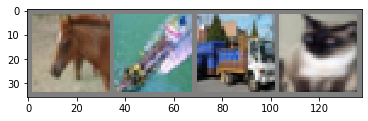

horse  ship truck   cat


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Construct the CNN.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the CNN and print out the number of parameters.

In [6]:
net = Net()
print(sum([p.numel() for p in net.parameters()]))

62006


# Define a Loss function and optimizer.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

 # Select the device to train the CNN! "cuda:0" means the first GPU device.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cpu


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

 # Mount your google drive to current virtual machine. And define the path to store the trained CNN parameters.

In [9]:
#from google.colab import drive
# drive.mount('/content/drive')
#PATH = 'cifar10_net.pth'

 # Train the CNN and store the best model based on the validation loss.

In [10]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.137
[1,  4000] loss: 1.808
[1,  6000] loss: 1.643
[1,  8000] loss: 1.556
[1, 10000] loss: 1.499
[1, 12000] loss: 1.443
[2,  2000] loss: 1.347
[2,  4000] loss: 1.345
[2,  6000] loss: 1.341
[2,  8000] loss: 1.316
[2, 10000] loss: 1.292
[2, 12000] loss: 1.262
[3,  2000] loss: 1.216
[3,  4000] loss: 1.227
[3,  6000] loss: 1.181
[3,  8000] loss: 1.190
[3, 10000] loss: 1.166
[3, 12000] loss: 1.183
[4,  2000] loss: 1.117
[4,  4000] loss: 1.111
[4,  6000] loss: 1.101
[4,  8000] loss: 1.107
[4, 10000] loss: 1.123
[4, 12000] loss: 1.109
Finished Training


# Save the trained mode.

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

 # Define the test dataset.

In [12]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


 # Visualize the test dataset.

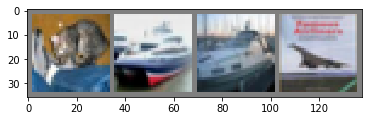

GroundTruth:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

 # Load the learned CNN parameters. This is required when you have trained the CNN and do no want to train it again by loading the learned parameters.

In [14]:
net.load_state_dict(torch.load(PATH))

 # Get the predictions for the first 4 images in the test dataset.

In [15]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


 # Infer on the whole test dataset.

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


# Get the Accuracy of each class

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 80 %
Accuracy of  bird : 43 %
Accuracy of   cat : 45 %
Accuracy of  deer : 41 %
Accuracy of   dog : 51 %
Accuracy of  frog : 67 %
Accuracy of horse : 69 %
Accuracy of  ship : 70 %
Accuracy of truck : 53 %


 # check the GPU device assigned by Google.

In [18]:
#get_ipython().system('ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi')
#print(subprocess.getoutput('nvidia-smi'))
